<a href="https://colab.research.google.com/github/lanyu0322/phd_semester1/blob/master/wamp_less_than_0_0035.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import time
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter as uf
from scipy.optimize import least_squares

#plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [7, 5]
import glob

In [0]:
from google.colab import drive
drive.mount('/content/drive')

# Define 4 pop model

In [0]:
# -- read in the average weekend counts
fname = os.path.join("drive", "My Drive", "lwir", "data", "nycdot", 
                     "avg_weekend_ts.feather")
weekend = uf(pd.read_feather(fname)["avg_counts"].values, 8)

In [0]:
# -- read temp and humidity data
tname = os.path.join("drive", "My Drive", "lwir", "data", "4_pop_fit", 
                     "temp_humidity.csv")
temp = pd.read_csv(tname)

In [0]:
# -- define gaussian
def gauss(xarr, x0, sig, scl):
  """ Create a 1D Gaussian """
  
  amp = scl / (sig * np.sqrt(2.0 * np.pi))
  val = -0.5 * ((xarr - x0) / sig)**2
  
  return amp * np.exp(val)


# -- define the model
def pop_model(param, xval):

  # -- determine which model is being used from length of param array
  nparam = len(param)

  # -- 3 population model
  if nparam == 10:
    m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, off = param
    wamp = 0.0

  # -- 4 population model
  elif nparam == 11:
    m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, wamp, off = param

  # -- ill-defined param array
  else:
    print("Nparam must be 10 (3pop) or 11 (4pop) model!")
    return None

  model = gauss(xval, m1, sd1, scl1) + gauss(xval, m2, sd2, scl2) + \
    gauss(xval, m3, sd3, scl3) + wamp * wendvals + off

  return model


# -- define model error
def res(param, xval, yval):

  return yval - pop_model(param, xval)

In [0]:
# -- set inital guess
avgs  = [35, 47, 70] 
sigs  = [3, 3, 3]
scls  = [5, 5, 5]
off   = [0.5]
wamp = [6]
param = avgs + sigs + scls + wamp + off


In [0]:
# -- set fit and model parameters and 
wendvals = weekend
xval_final = np.arange(96)
bounds_lo = [24., 44., 64., 2.0, 2.0, 2.0, 0, 0, 0, 0, -np.inf]
bounds_hi = [44., 64., 80., 8., 8., 8., np.inf, np.inf, np.inf, np.inf, np.inf]

# Get time series data for each camera each day

In [0]:
# -- read the outliers have no three peak
bind = [175, 409, 172, 176, 165, 170, 173, 360, 501, 537, 545, 795, 547, 845, 
        845, 899, 891, 934, 940, 970, 475, 989, 791, 988, 291, 530, 909, 248, 
        500, 177, 968, 517, 805, 932, 432, 452, 847, 790, 969, 841, 446, 893, 
        715]

In [0]:
# -- read multi_files and combine them together
path = r'drive/My Drive/lwir/data/nycdot/counts_wd_cam'
all_files = glob.glob(path + "/*.feather")

li = []
cnum = []

for filename in all_files:

    if ("175" in filename) | ("409" in filename) | ("172" in filename) |\
    ("176" in filename) | ("165" in filename) | ("170" in filename) |\
    ("173" in filename) | ("360" in filename) | ("501" in filename) |\
    ("537" in filename) | ("545" in filename) | ("795" in filename) |\
    ("547" in filename) | ("845" in filename) | ("899" in filename) |\
    ("891" in filename) | ("934" in filename) | ("940" in filename) |\
    ("970" in filename) | ("248" in filename) | ("452" in filename) |\
    ("475" in filename) | ("500" in filename) | ("847" in filename) |\
    ("989" in filename) | ("177" in filename) | ("790" in filename) |\
    ("791" in filename) | ("968" in filename) | ("969" in filename) |\
    ("988" in filename) | ("517" in filename) | ("841" in filename) |\
    ("291" in filename) | ("805" in filename) | ("446" in filename) |\
    ("530" in filename) | ("932" in filename) | ("893" in filename) |\
    ("909" in filename) | ("432" in filename) | ("715" in filename):
      continue

    df = pd.read_feather(filename)
    cum = filename.split("_")[-1].split("_")[0]
    li.append(df)
    cnum.append(cum)

frame = pd.concat(li, axis=0, ignore_index=True)

In [0]:
# -- create day and time column
frame["day"] = frame["date"].dt.date
frame["time"] = frame["date"].dt.time
frame

,date,count,day,time
0,2017-06-28 00:00:00,0.250000,2017-06-28,00:00:00
1,2017-06-28 00:15:00,0.181818,2017-06-28,00:15:00
2,2017-06-28 00:30:00,0.000000,2017-06-28,00:30:00
3,2017-06-28 00:45:00,0.181818,2017-06-28,00:45:00
4,2017-06-28 01:00:00,0.083333,2017-06-28,01:00:00
...,...,...,...,...
342235,2017-09-11 22:45:00,2.000000,2017-09-11,22:45:00
342236,2017-09-11 23:00:00,2.000000,2017-09-11,23:00:00
342237,2017-09-11 23:15:00,2.000000,2017-09-11,23:15:00
342238,2017-09-11 23:30:00,2.000000,2017-09-11,23:30:00


In [0]:
# -- get available date data
day = frame.groupby("day").count().reset_index()


In [0]:
# -- groupby day and get the values
ff1a = frame.groupby("time")

avg_frame = []
for ind, gp in ff1a:
  avg_frame.append(gp["count"].values)


In [0]:
# -- replace nans to nearest average counts
avg_frame = pd.DataFrame(avg_frame)
fnan = avg_frame.ffill()
bnan = avg_frame.bfill()
avg_count = 0.5*(fnan + bnan).T

In [0]:
# -- add date for groupby
def new_sratio(sratio):
  sratio_day = []
  for index, row in sratio.iterrows():
   
    day_index = index % 31
    new_row = []
    new_row.append(row["sratio"])
    new_row.append(day["day"].iloc[day_index]) #add a new sublist to each sratio
    sratio_day.append(new_row)

  return sratio_day

# 1a. For a given day, calculate the sratio for each camera and average.

In [0]:
# -- transfer to dataframe 
avg_la = pd.DataFrame(avg_count)


cam_avg = []
for i in range(115):
  if i == 0:
    avg_cam = avg_la.iloc[0:31].mean()
  else:
    ii = i * 31
    jj = ii + 31
    avg_cam = avg_la.iloc[ii:jj].mean()
  cam_avg.append(avg_cam)

cam_avg = pd.DataFrame(cam_avg)

In [0]:
# -- set fit and model parameters and 
wendvals = weekend
xval_final = np.arange(96)
bounds_lo = [24., 44., 64., 2.0, 2.0, 2.0, 0, 0, 0, 0, -np.inf]
bounds_hi = [44., 64., 80., 8., 8., 8., np.inf, np.inf, np.inf, np.inf, np.inf]
# -- optimize
plsq = []
for ii in range(len(cam_avg)):
  #print("working on day {0}".format(ii))

  plsq.append(least_squares(res, param, bounds=(bounds_lo, bounds_hi), 
                            args=(xval_final, cam_avg.iloc[ii])))

In [0]:
# -- put fit results into DataFrame
result_1a = pd.DataFrame(plsq)["x"].values

df1a = pd.DataFrame(np.vstack(result_1a), 
                     columns=["m1", "m2", "m3", "sd1", "sd2", "sd3", 
                              "scl1", "scl2", "scl3", "wamp", "off"])

# Get the dropped camera ID

In [0]:
# -- add camera number
df1a["cnum"] = cnum

# -- keep camers only wamp less than 0.0035
drop_cam = df1a[df1a["wamp"] > 0.0035]
dcnum = drop_cam["cnum"]

# -- write to csv
oname = os.path.join("drive", "My Drive", "lwir", "data", "4_pop_fit", 
                     "bad_cam_id.csv")
dcnum.to_csv(oname, index=False)

In [0]:
# -- keep only numeric
import re
drop_id = dcnum.str.replace(r'[^0-9]+', '')

id = []

for e in drop_id:
  res = e[1:]
  id.append(res)

In [0]:
# -- creat a dataframe and merge
id = pd.DataFrame(id)
id["id"] = id

In [0]:
# -- read in the weekday counts
camera_fname = os.path.join("drive", "My Drive", "lwir", "data", "nycdot", 
                            "cams_ft_wd.feather")
camera = pd.read_feather(camera_fname)

In [0]:
# -- get the lat/lon of the dropped cameras
camera["cam_id"] = camera["cam_id"].astype(str)
cam_id = camera.merge(id, left_on="cam_id", right_on="id")

<Figure size 640x480 with 0 Axes>

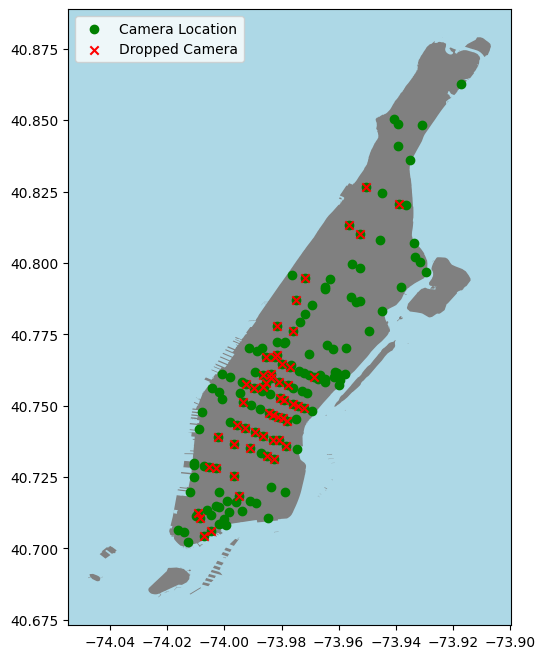

In [0]:
# -- plotting dropped cameras

try:
  import geopandas as gp
except:
  !pip install geopandas


fig = plt.figure()
plt.rcParams.update(plt.rcParamsDefault)
# -- plot it
#    (Borough geojson from: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm)
bpath = os.path.join("drive", "My Drive", "lwir", "data", "boro_boundaries")
bname = "Borough Boundaries.geojson"
boros = gp.read_file(os.path.join(bpath, bname))
boros = boros[boros.boro_name == "Manhattan"]
# -- set the parks geometries file name
dpath = os.path.join("drive", "My Drive", "lwir", "data", "parks", "properties")
fname = "geo_export_5b605687-0f81-4fe4-9fb7-ec27cd43ab5f.shp"
# -- load the parks geometries and convert to NY State Plane
parks = gp.read_file(os.path.join(dpath, fname))
parks_m = parks[parks.borough == "M"]

# -- plot it
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_facecolor("lightblue")
boros.plot(color="grey", ax=ax, legend=True)
#parks_m.plot(color="orange", ax=ax, legend=True)

ax.scatter(camera.lon, camera.lat, color="green", label='Camera Location')
ax.scatter(cam_id.lon, cam_id.lat, marker="x", color="red", label='Dropped Camera')

ax.legend(loc='upper left')


# plotting for cameras' wamp has less then 0.0035

In [0]:
# -- read in the bad camer id 
cname = os.path.join("drive", "My Drive", "lwir", "data", "4_pop_fit", 
                     "bad_cam_id.csv")
cam_bad = pd.read_csv(cname)

In [0]:
# -- read cam id for outliers that have no three peak
bind = [175, 409, 172, 176, 165, 170, 173, 360, 501, 537, 545, 795, 547, 845, 
        845, 899, 891, 934, 940, 970, 475, 989, 791, 988, 291, 530, 909, 248, 
        500, 177, 968, 517, 805, 932, 432, 452, 847, 790, 969, 841, 446, 893, 
        715]

bad_camera = []

for v in cam_bad.values.tolist():
  bad_camera.append(int(v.pop().split(".")[0]))

final_bad_cam = list(set(bind + bad_camera))


In [0]:
# -- read multi_files and combine them together
path = r'drive/My Drive/lwir/data/nycdot/counts_wd_cam'
all_files = glob.glob(path + "/*.feather")

cam = []
num = []

for filename in all_files:
  valid = True
  for b_id in final_bad_cam:
    if (str(b_id) in filename):
      valid = False
      break
  if valid:
    df0 = pd.read_feather(filename)
    cum = filename.split("_")[-1].split("_")[0]
    cam.append(df0)
    num.append(cum)

frame_drop1 = pd.concat(cam, axis=0, ignore_index=True)

In [0]:
frame_drop1

,date,count
0,2017-06-28 00:00:00,0.250000
1,2017-06-28 00:15:00,0.181818
2,2017-06-28 00:30:00,0.000000
3,2017-06-28 00:45:00,0.181818
4,2017-06-28 01:00:00,0.083333
...,...,...
175579,2017-09-11 22:45:00,0.000000
175580,2017-09-11 23:00:00,0.000000
175581,2017-09-11 23:15:00,0.000000
175582,2017-09-11 23:30:00,0.000000


In [0]:
# # -- read multi_files and combine them together
# path = r'drive/My Drive/lwir/data/nycdot/counts_wd_cam'
# all_files = glob.glob(path + "/*.feather")

# cam = []
# num = []


# for filename in all_files:

#     if ("175" in filename) | ("409" in filename) | ("172" in filename) |\
#     ("176" in filename) | ("165" in filename) | ("170" in filename) |\
#     ("173" in filename) | ("360" in filename) | ("501" in filename) |\
#     ("537" in filename) | ("545" in filename) | ("795" in filename) |\
#     ("547" in filename) | ("845" in filename) | ("899" in filename) |\
#     ("891" in filename) | ("934" in filename) | ("940" in filename) |\
#     ("970" in filename) | ("248" in filename) | ("452" in filename) |\
#     ("475" in filename) | ("500" in filename) | ("847" in filename) |\
#     ("989" in filename) | ("177" in filename) | ("790" in filename) |\
#     ("791" in filename) | ("968" in filename) | ("969" in filename) |\
#     ("988" in filename) | ("517" in filename) | ("841" in filename) |\
#     ("291" in filename) | ("805" in filename) | ("446" in filename) |\
#     ("530" in filename) | ("932" in filename) | ("893" in filename) |\
#     ("909" in filename) | ("432" in filename) | ("715" in filename) |\
#     ("168" in filename) | ("171" in filename) | ("166" in filename) |\
#     ("169" in filename) | ("180" in filename) | ("181" in filename) |\
#     ("179" in filename) | ("187" in filename) | ("338" in filename) |\
#     ("339" in filename) | ("347" in filename) | ("351" in filename) |\
#     ("361" in filename) | ("398" in filename) | ("403" in filename) |\
#     ("404" in filename) | ("406" in filename) | ("414" in filename) |\
#     ("413" in filename) | ("415" in filename) | ("416" in filename) |\
#     ("419" in filename) | ("421" in filename) | ("420" in filename) |\
#     ("489" in filename) | ("495" in filename) | ("504" in filename) |\
#     ("503" in filename) | ("506" in filename) | ("509" in filename) |\
#     ("508" in filename) | ("510" in filename) | ("511" in filename) |\
#     ("527" in filename) | ("522" in filename) | ("526" in filename) |\
#     ("523" in filename) | ("529" in filename) | ("531" in filename) |\
#     ("535" in filename) | ("542" in filename) | ("551" in filename) |\
#     ("717" in filename) | ("722" in filename) | ("789" in filename) |\
#     ("794" in filename) | ("741" in filename) | ("838" in filename) |\
#     ("846" in filename) | ("937" in filename) | ("967" in filename) |\
#     ("1028" in filename) | ("1038" in filename) | ("740" in filename) |\
#     ("725" in filename) | ("739" in filename):
#       continue
    

#     df0 = pd.read_feather(filename)
#     cum = filename.split("_")[-1].split("_")[0]
#     cam.append(df0)
#     num.append(cum)

# frame_drop = pd.concat(cam, axis=0, ignore_index=True)

In [0]:
# -- read multi_files and combine them together
path = r'drive/My Drive/lwir/data/nycdot/counts_wd_cam'
all_files = glob.glob(path + "/*.feather")

cam = []
num = []

for filename in all_files:

    df0 = pd.read_feather(filename)
    cum = filename.split("_")[-1].split("_")[0]
    cam.append(df0)
    num.append(cum)

frame_drop = pd.concat(cam, axis=0, ignore_index=True)

In [0]:
define 

In [0]:
df1asub = fram[frame["cnum"].isin(cnum)].drop

In [0]:
# -- create day and time column
frame_drop["day"] = frame_drop["date"].dt.date
frame_drop["time"] = frame_drop["date"].dt.time
frame_drop

,date,count,day,time
0,2017-06-28 00:00:00,0.250000,2017-06-28,00:00:00
1,2017-06-28 00:15:00,0.181818,2017-06-28,00:15:00
2,2017-06-28 00:30:00,0.000000,2017-06-28,00:30:00
3,2017-06-28 00:45:00,0.181818,2017-06-28,00:45:00
4,2017-06-28 01:00:00,0.083333,2017-06-28,01:00:00
...,...,...,...,...
175579,2017-09-11 22:45:00,0.000000,2017-09-11,22:45:00
175580,2017-09-11 23:00:00,0.000000,2017-09-11,23:00:00
175581,2017-09-11 23:15:00,0.000000,2017-09-11,23:15:00
175582,2017-09-11 23:30:00,0.000000,2017-09-11,23:30:00


In [0]:
# -- get available date data
day_drop = frame_drop.groupby("day").count().reset_index()

In [0]:
# -- groupby day and get the values

fft = frame_drop.groupby("time")

avg_frame_drop = []
for ind, gp in fft:
  avg_frame_drop.append(gp["count"].values)

In [0]:
# -- replace nans to nearest average counts
avg_frame_drop = pd.DataFrame(avg_frame_drop)
fnan_drop = avg_frame_drop.ffill()
bnan_drop = avg_frame_drop.bfill()
avg_count_drop = 0.5*(fnan_drop + bnan_drop).T

# 2b. For a given day, standardize each camera and repeat 2a.

In [0]:
# -- get the counts
avg_2b = avg_count_drop.values.copy()

In [0]:
# -- standardized data
avg_2b_m = avg_2b.mean(axis=1, keepdims=True)
avg_2b_std = avg_2b.std(axis=1, keepdims=True)
avg_2b_st = (avg_2b - avg_2b_m) / (avg_2b_std + (avg_2b_std == 0))

In [0]:
# -- build dataframe for st counts
avg_2b_st = pd.DataFrame(avg_2b_st)

In [0]:
# -- define add date

def add_date(count):
  count_day = []
  for index, row in count.iterrows():
   
    day_index = index % 31
    new_row = []
    for i in range(len(row)):
      new_row.append(row[i])
    new_row.append(day["day"].iloc[day_index]) #add a new sublist to each row
    count_day.append(new_row)

  return count_day

In [0]:
# -- add date for st counts
avg_2b_date = pd.DataFrame(add_date(avg_2b_st))

In [0]:
# -- rename dataframe 96 to day
avg_2b_date = avg_2b_date.rename(columns = {96:'day'})

In [0]:
# -- get avg_st counts
avg_std_date = avg_2b_date.groupby("day").mean()

In [0]:
# -- optimize
# -- set fit and model parameters and 
wendvals = weekend
xval_final = np.arange(96)
bounds_lo = [24., 44., 64., 2.0, 2.0, 2.0, 0, 0, 0, 0, -np.inf]
bounds_hi = [44., 64., 80., 8., 8., 8., np.inf, np.inf, np.inf, np.inf, np.inf]

plsq_2b = []
for ii in range(len(avg_std_date)):
  #print("working on day {0}".format(ii))

  plsq_2b.append(least_squares(res, param, bounds=(bounds_lo, bounds_hi), 
                            args=(xval_final, avg_std_date.iloc[ii])))



In [0]:
# -- put fit results into DataFrame
result_2b = pd.DataFrame(plsq_2b)["x"].values
df2b = pd.DataFrame(np.vstack(result_2b), 
                     columns=["m1", "m2", "m3", "sd1", "sd2", "sd3", 
                              "scl1", "scl2", "scl3", "wamp", "off"])

In [0]:
# -- calculate sratio 
df2b["sratio"] = df2b["scl2"] / (0.5 * (df2b["scl1"] + df2b["scl3"]))

In [0]:
# -- add date column
sratio_2b = pd.DataFrame(new_sratio(df2b))
sratio_2b["wamp"] = df2b["wamp"]
sratio_2b["scl1"] = df2b["scl1"]
sratio_2b["scl2"] = df2b["scl2"]
sratio_2b["scl3"] = df2b["scl3"]
sratio_2b.columns = ["sratio", "date", "wamp", "scl1", "scl2", "scl3"]

In [0]:
# -- subset humidity and temp to our research period
sratio_2b["date"] = sratio_2b["date"].astype(str)
temp_day_2b = sratio_2b.merge(temp, left_on="date", right_on="day")

In [0]:
# -- import statmodels using the formula api
import statsmodels.formula.api as sm
# -- first build the model
model = sm.ols("temp ~ sratio", data=temp_day_2b)

# -- now fit the model to the data
result = model.fit()
# -- summarize the model fit
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   temp   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     9.386
Date:                Wed, 06 May 2020   Prob (F-statistic):            0.00469
Time:                        16:28:02   Log-Likelihood:                -96.897
No. Observations:                  31   AIC:                             197.8
Df Residuals:                      29   BIC:                             200.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     86.7812      2.120     40.937      0.0

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


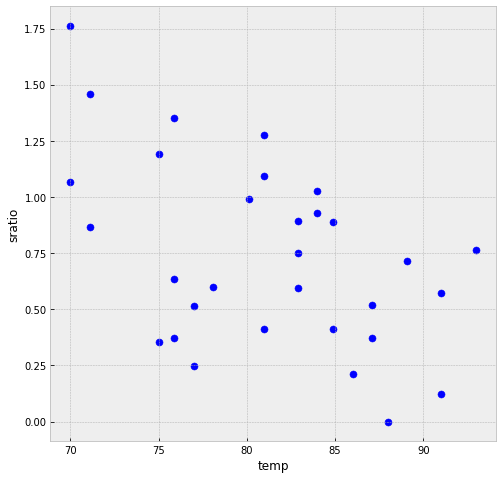

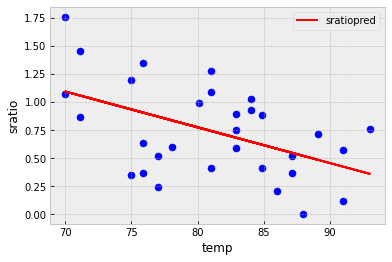

In [0]:
# -- create a scatter plot of temp and sratio
temp_day_2b.plot.scatter("temp", "sratio", figsize=[8, 8], s=50)
outfile = os.path.join("drive", "My Drive", "lwir", "output",
                       "temp_sratio(2b).png")
plt.savefig(outfile)

# -- create a linear prediction of temp and sratio plot
import statsmodels.formula.api as sm
sub_2b = temp_day_2b.copy()
sub_2b["sratiopred"] = sm.ols("sratio ~ temp", data=sub_2b).fit().predict(sub_2b)
ax = sub_2b.plot.scatter("temp", "sratio", s=50)
sub_2b.plot("temp", "sratiopred", c = "r", ax=ax)

# outfile = os.path.join("drive", "My Drive", "lwir", "output",
#                        "temp_sratio(2b_pred_wamp_less_0.0035).png")
# plt.savefig(outfile)

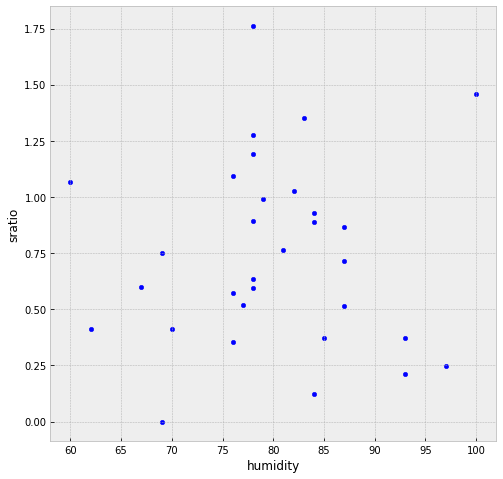

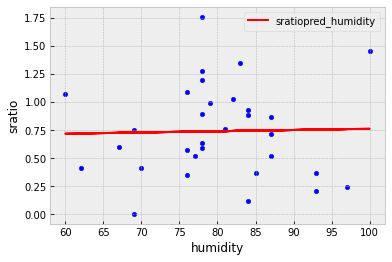

In [0]:
# -- create a scatter plot of humidity\t and sratio
temp_day_2b.plot.scatter("humidity", "sratio", figsize=[8, 8])
outfile = os.path.join("drive", "My Drive", "lwir", "output",
                       "humi_sratio(2b).png")
plt.savefig(outfile)

# -- create a linear prediction of humidity\t and sratio plot
sub0_2b = temp_day_2b.copy()
sub0_2b["sratiopred_humidity"] = sm.ols("sratio ~ humidity", data=sub0_2b).fit().predict(sub0_2b)
ax = sub0_2b.plot.scatter("humidity", "sratio")
sub0_2b.plot("humidity", "sratiopred_humidity", c = "r", ax=ax)